In [17]:
import os
import setGPU
import numpy as np
from collections import namedtuple
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
print('tensorflow version: ', tf.__version__)
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../../')))

import vae.vae_particle as vap
import vae.losses as losses
import pofah.path_constants.sample_dict_file_parts_input as sdi
import pofah.util.experiment as expe
import pofah.util.sample_factory as safa
import util.data_generator as dage
import sarewt.data_reader as dare
import pofah.phase_space.cut_constants as cuts
import training as tra
import tensorflow.keras.layers as klayers
from importlib import reload


tensorflow version:  2.3.0


In [239]:
# ********************************************************
#       runtime params
# ********************************************************

Parameters = namedtuple('Parameters', 'run_n input_shape kernel_sz kernel_ini_n beta epochs train_total_n gen_part_n valid_total_n batch_n z_sz activation initializer learning_rate max_lr_decay lambda_reg')
params = Parameters(run_n=113, 
                    input_shape=[(100,2),(100,3)],
                    kernel_sz=(1,3), 
                    kernel_ini_n=12,
                    beta=0, 
                    epochs=20, 
                    train_total_n=int(10e6), 
                    valid_total_n=int(1e6), 
                    gen_part_n=int(5e5), 
                    batch_n=256, 
                    z_sz=12,
                    activation='elu',
                    initializer='he_uniform',
                    learning_rate=0.001,
                    max_lr_decay=8, 
                    lambda_reg=0.0) # 'L1L2'



In [85]:
nodes_n=100
feat_sz=3

In [237]:
import tensorflow.keras.layers as klayers


class _DotDict:
    pass

setting = _DotDict()
setting.name = 'PN'
 # conv_params: list of tuple in the format (K, (C1, C2, C3))
setting.conv_params = [
   (15, ([20,20,20])),
  #      (7, (32, 32, 32)),
  #      (7, (64, 64, 64)),
        ]
#setting.conv_params_decoder = [60,32,16,8, 5]
setting.conv_params_encoder_input = 20 #64 #20
setting.conv_params_encoder = []
setting.conv_params_decoder = [10]  #[32,16,8]
setting.with_bn = True
# conv_pooling: 'average' or 'max' #indeed average seems to perform better
setting.conv_pooling = 'average'
setting.conv_linking = 'sum' #concat or sum
setting.num_points = nodes_n #num of original consituents
setting.num_features = feat_sz #num of original features
setting.input_shapes = {'points': [nodes_n,feat_sz-1],'features':[nodes_n,feat_sz]}
setting.latent_dim = 3
setting.ae_type = 'vae'  #ae or vae 
setting.kl_warmup_time = 10
setting.activation = klayers.LeakyReLU(alpha=0.1)


In [238]:
import vae.vae_base as vae_base
reload(vae_base)
import vae.vae_particlenet as vae_pn
reload(vae_pn)

vae = vae_pn.VAE_ParticleNet(beta=params.beta,setting=setting,kernel_ini_n=params.kernel_ini_n,name='PN_AE_',input_shape=params.input_shape)
a = [1]
vae.build(a)
#


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             [(None, 100, 2)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_Transpose_70 (Tenso [(None, 2, 100)]     0           points[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Mul_105 (TensorFlow [(None, 100, 2)]     0           points[0][0]                     
                                                                 points[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_BatchMatMulV2_35 (T [(None, 100, 100)]   0           points[0][0]               

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input_0 (InputLayer)      [(None, 100, 2)]     0                                            
__________________________________________________________________________________________________
model_input_1 (InputLayer)      [(None, 100, 3)]     0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 3), (None, 3 13106       model_input_0[0][0]              
                                                                 model_input_1[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 100, 3)       8033        encoder[0][0]                  

In [ ]:
# *******************************************************
#                       training options
# *******************************************************

optimizer = tf.keras.optimizers.Adam(learning_rate=params.learning_rate)
loss_fn = losses.threeD_loss

In [36]:
import h5py

import ADgvae.utils.preprocessing as prepr
reload(prepr)

DATA_PATH = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/input/'
#filename_bg = DATA_PATH + 'QCD_training_data_02_08_2021.h5'
filename_bg = DATA_PATH + 'QCD_training_data_100const_03_08_2021.h5'
inFile = h5py.File(filename_bg, 'r')
particles_bg = inFile['particle_bg'][0:int(5*10e4)]
particles_bg_valid = inFile['particle_bg_valid'][0:int(1*10e4)]
particles_bg_test = inFile['particle_bg_test'][0:int(1*10e4)]
nodes_n = particles_bg.shape[1]
feat_sz = particles_bg.shape[2]

In [228]:
train_ds = tf.data.Dataset.from_tensor_slices((particles_bg[:50000,:,0:2],particles_bg[:50000,:,:]))

batched_dataset = train_ds.batch(1000)
#for step, x_batch_train in enumerate(batched_dataset):
#    print(x_batch_train)
#    break

In [240]:
reload(tra)
import setGPU
trainer = tra.TrainerParticleNet(optimizer=optimizer, beta=params.beta, patience=3, min_delta=0.03, max_lr_decay=params.max_lr_decay, lambda_reg=params.lambda_reg)

losses_reco, losses_valid = trainer.train(vae=vae, loss_fn=loss_fn,
                                          train_ds=batched_dataset, valid_ds=batched_dataset,
                                          epochs=params.epochs, model_dir='/eos/user/n/nchernya/MLHEP/AnomalyDetection/')




### [5.8 16:21:22] Start of epoch 0
Step 0: mean reco loss 1.4081, KL loss 0.5318 (in one batch)
Seen so far: 256 samples
### [Epoch 0 - 18.08 sec]: train loss reco 1.005 kl 0.265, val loss reco 0.329 kl 0.009 (mean / batch) ###

### [5.8 16:21:40] Start of epoch 1
Step 0: mean reco loss 0.8493, KL loss 0.1881 (in one batch)
Seen so far: 256 samples
### [Epoch 1 - 14.96 sec]: train loss reco 0.737 kl 0.165, val loss reco 0.322 kl 0.024 (mean / batch) ###

### [5.8 16:21:55] Start of epoch 2
Step 0: mean reco loss 0.6506, KL loss 0.1515 (in one batch)
Seen so far: 256 samples
### [Epoch 2 - 15.04 sec]: train loss reco 0.599 kl 0.133, val loss reco 0.304 kl 0.033 (mean / batch) ###
------- Early stopping for last 3 validation losses [0.3381467, 0.34579763, 0.3377257]-------
decreasing learning rate from 2.700e-05 to 8.100e-06

### [5.8 16:22:10] Start of epoch 3
Step 0: mean reco loss 0.5481, KL loss 0.1256 (in one batch)
Seen so far: 256 samples
### [Epoch 3 - 15.07 sec]: train loss re

In [241]:


tra.plot_training_results(losses_reco, losses_valid, '/eos/user/n/nchernya/MLHEP/AnomalyDetection/')

#vae.save(path='/eos/user/n/nchernya/MLHEP/AnomalyDetection/')

In [242]:
reload(tra)
loss_fn = losses.threeD_loss

reco_j1, loss_j1_reco, loss_j1_kl = tra.predict_particle_net(vae.model, loss_fn, batched_dataset)


500

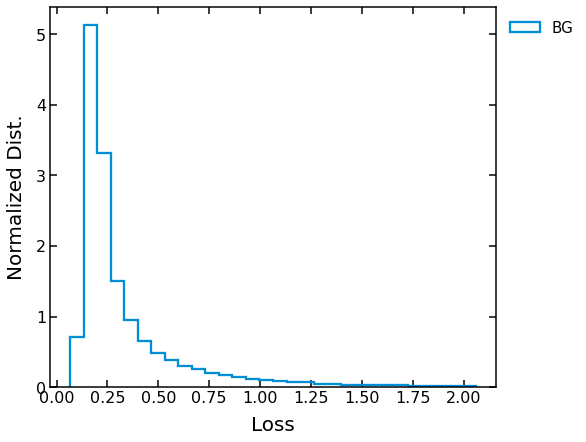

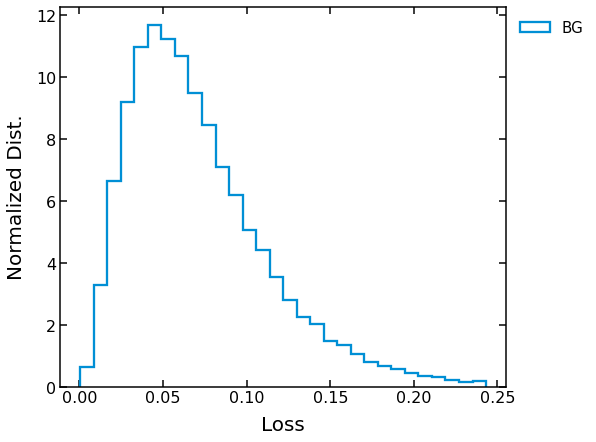

In [243]:
import matplotlib.pyplot as plt
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

for loss in [loss_j1_reco, loss_j1_kl ]:
    max_score = 1.1*np.quantile(loss,0.99)
    min_score = np.min(loss)#,np.max(loss_bg_dist))
    bins = 30
    # plot BG
    plt.figure()
    plt.hist(loss, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=2.3)
    #plt.semilogy()
    plt.xlabel("Loss")
    plt.ylabel("Normalized Dist.")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.show()

In [217]:
tf.data.experimental.cardinality(train_ds.batch(1,drop_remainder=True)).numpy()

2000